In [2]:
##Note you have to use SPFT custom environment for this to work
from statistics import mode
import yaml
import numpy as np
from glob import glob
from os.path import join
import matplotlib.pyplot as plt
import sys
sys.path.append('../../')
from spft import *
import pandas as pd
import os


**Code to decypher data**

In [3]:
#Gather the participants file names
### P2 day 1 file was corrupted...
PiD1name = sorted(list(set(glob("source/VOL*x1_Pilot_Behave-R_Only_LRN_out-file.yml")) - set(glob("source/VOL02x1_Pilot_Behave-R_Only_LRN_out-file.yml"))))
PiD2name = sorted(glob("source/VOL*x2_Pilot_Behave-R_Only_LRN_out-file.yml"))
print(PiD1name)
print(PiD2name)

['source/VOL01x1_Pilot_Behave-R_Only_LRN_out-file.yml', 'source/VOL03x1_Pilot_Behave-R_Only_LRN_out-file.yml', 'source/VOL04x1_Pilot_Behave-R_Only_LRN_out-file.yml', 'source/VOL05x1_Pilot_Behave-R_Only_LRN_out-file.yml']
['source/VOL01x2_Pilot_Behave-R_Only_LRN_out-file.yml', 'source/VOL02x2_Pilot_Behave-R_Only_LRN_out-file.yml', 'source/VOL03x2_Pilot_Behave-R_Only_LRN_out-file.yml', 'source/VOL04x2_Pilot_Behave-R_Only_LRN_out-file.yml', 'source/VOL05x2_Pilot_Behave-R_Only_LRN_out-file.yml']


In [20]:
def compute_block_mean(dset, seq_type='LRN', trials_per_block=3, 
                     good_data_vec = np.array([1,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1],dtype=bool),
                     metric='lag_xcorr_ms'):
    _d_vec = dset['all'][seq_type][metric]
    
    num_blocks = int(_d_vec.shape[0]/trials_per_block)
    print(str(num_blocks)+" blocks")
    _o_vec = np.zeros(num_blocks)
    for block in np.arange(0,num_blocks):
        start_pos = block*trials_per_block
        end_pos = block*trials_per_block + trials_per_block
        _o_vec[block] = np.mean(_d_vec[start_pos:end_pos][good_data_vec[start_pos:end_pos]]) 
    return _o_vec

In [11]:
# #Quick test of cutting data from the start of the trial

# fname = 'source/VOL02x2_Pilot_Behave-R_Only_LRN_out-file.yml'
# data = load_yaml(fname)

# t1 = score_spft_data(data,device_idx=0,description = "RHP", 
#         reference_designation='leftReference', trial_type_keys = ['LRN','RST'],
#         exclude_meta_keys = ['blocks','devices'], save_trial_data=True,
#         global_constraint=None,sakoe_chiba_radius=None,itakura_max_slope=None,
#         normalize_path_len=True)

# t2 = score_spft_data(data,device_idx=0,description = "RHP", 
#         reference_designation='leftReference', trial_type_keys = ['LRN','RST'],
#         exclude_meta_keys = ['blocks','devices'], save_trial_data=True,
#         global_constraint=None,sakoe_chiba_radius=None,itakura_max_slope=None,
#         normalize_path_len=True, cut_time_flag='start',cut_time=1000)

# plt.plot(t1['trial_data']['ref_interp'][0])
# plt.plot(t2['trial_data']['ref_interp'][0])



In [14]:
#Loop to create a dictionary of scored spft results per participant
PiD1 = {}
# Pi = ['Pi1', 'Pi3', 'Pi4', 'Pi5']
# Pinum = 0
for fname in PiD1name:
    data = load_yaml(fname) #loading each participants yml data
    ID = os.path.basename(fname).split("_")[0][:-2]
    # if fname == '/data/neuralabc/kaemik/SPFT_GE/source/VOL*x1_Pilot_Behave-R_Only_LRN_out-file.yml':
    PiD1[ID] = score_spft_data(data,device_idx=0,description = "RHP", 
        reference_designation='leftReference', trial_type_keys = ['LRN','RST'],
        exclude_meta_keys = ['blocks','devices'], save_trial_data=True,
        global_constraint=None,sakoe_chiba_radius=None,itakura_max_slope=None,
        normalize_path_len=True,cut_time_flag='start',cut_time=1000) #scoring each participants spft data and inputting it into a key corresponding to the participant number
    # Pinum = Pinum + 1
# print(PiD1['Pi1'].keys())

In [15]:
PiD2 = {}
# Pinum = 0
for fname in PiD2name:
    data = load_yaml(fname) #loading each participants yml data
    # Pinum = Pinum + 1
    ID = os.path.basename(fname).split("_")[0][:-2]
    PiD2[ID] = score_spft_data(data,device_idx=0,description = "RHP", 
        reference_designation='leftReference', trial_type_keys = ['LRN','RST'],
        exclude_meta_keys = ['blocks','devices'], save_trial_data=True,
        global_constraint=None,sakoe_chiba_radius=None,itakura_max_slope=None,
        normalize_path_len=True,cut_time_flag='start',cut_time=1000) #scoring each participants spft data and inputting it into a key corresponding to the participant number
# print(PiD2.keys())
fname = 'source/VOL02x2_Pilot_Behave-R_Only_LRN_out-file.yml'
data = load_yaml(fname)
bad_sub_ID = 'VOL02'
PiD2[bad_sub_ID] = score_spft_data(data,device_idx=0,description = "RHP", 
        reference_designation='leftReference', trial_type_keys = ['LRN','RST'],
        exclude_meta_keys = ['blocks','devices'], save_trial_data=True,
        global_constraint=None,sakoe_chiba_radius=None,itakura_max_slope=None,
        normalize_path_len=True,cut_time_flag='start',cut_time=1000) #scoring each participants spft data and inputting it into a key corresponding to the participant number

9 blocks
9 blocks
9 blocks
9 blocks
9 blocks
9 blocks


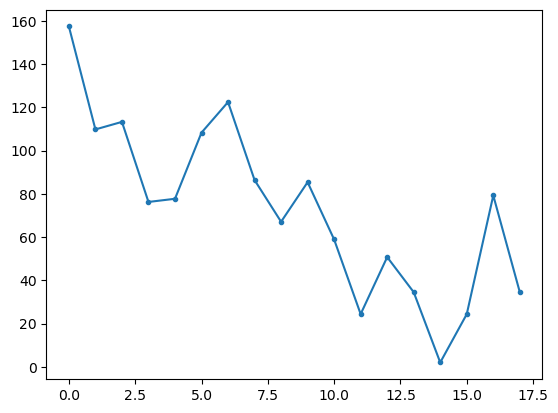

In [32]:
#VOL02 needs to have some data imputed based on the mean change in the previous group.
norm_data_to_1st_block = True
bad_sub_ID = 'VOL02'
metric = 'lag_xcorr_ms'
good_data_vec = np.ones(27,dtype=bool)
d1 = np.zeros((4,9)) #hard-coded for now
for idx,pi in enumerate(PiD1.keys()):
    d1[idx,:] = compute_block_mean(PiD1[pi],metric=metric,good_data_vec=good_data_vec)

diff_of_mean_perf_d1 = np.diff(d1.mean(axis=0))

b1_of_d2 = compute_block_mean(PiD2[bad_sub_ID],metric=metric,good_data_vec=good_data_vec)[0]
bad_sub_d1 = b1_of_d2-diff_of_mean_perf_d1
bad_sub_d1_2 = np.hstack([d1.mean(axis=0)[0],bad_sub_d1, compute_block_mean(PiD2[bad_sub_ID],metric=metric,good_data_vec=good_data_vec)])
plt.plot(bad_sub_d1_2,'.-')


9 blocks
9 blocks
9 blocks
9 blocks
9 blocks
9 blocks
9 blocks
9 blocks


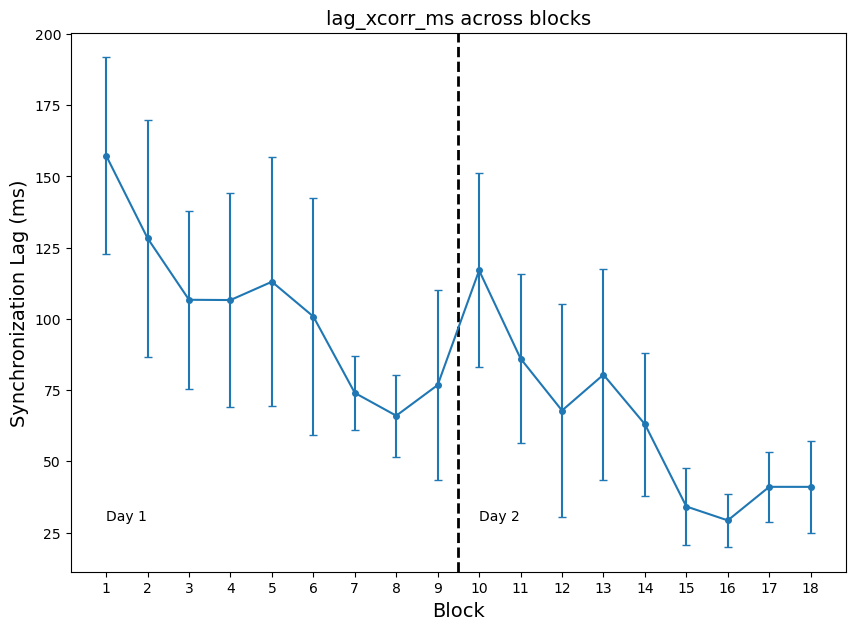

In [33]:
#summarize the data for plotting
norm_data_to_1st_block = False

good_data_vec = np.ones(27,dtype=bool)
d1_2 = {}
for pi in PiD1.keys():
    d1_2[pi] = np.hstack([compute_block_mean(PiD1[pi],metric=metric,good_data_vec=good_data_vec),
                          compute_block_mean(PiD2[pi],metric=metric,good_data_vec=good_data_vec)])



d1_2[bad_sub_ID] = bad_sub_d1_2
if norm_data_to_1st_block:
    norm_txt = 'relative '
    for pi in d1_2.keys():
            # if norm_data_to_1st_block:
        d1_2[pi] = d1_2[pi]/d1_2[pi][0]
else:
    norm_txt = ""
for idx,pi in enumerate(d1_2):
    if idx ==0:
        plotting_d = np.zeros((len(d1_2.keys()),d1_2[pi].shape[0]))
    plotting_d[idx,:] = d1_2[pi]
    # if norm_data_to_1st_block:
    #     plotting_d[idx,:] = plotting_d[idx,:]/plotting_d[idx,0]


# plt.plot(plotting_d.mean(axis=0))
plt.figure(figsize=(10,7))
yerr = np.std(plotting_d,axis=0)/(np.sqrt(plotting_d.shape[0]))
_ = plt.errorbar(np.arange(1,plotting_d.shape[1]+1),plotting_d.mean(axis=0),yerr=yerr,capsize=3, fmt="-o", markersize=4)
_ = plt.xticks(np.arange(1,plotting_d.shape[1]+1))
_ = plt.title(f'{norm_txt}{metric} across blocks',fontsize=14)
_ = plt.axvline(9.5,color='k',linestyle='--',linewidth=2)
plt.xlabel('Block',fontsize=14)
if norm_data_to_1st_block:
    plt.ylabel('Synchronization Lag (relative to b1)',fontsize=14)
else:
    plt.ylabel('Synchronization Lag (ms)',fontsize=14)
_ = plt.text(1,np.min(plotting_d.mean(axis=0)),'Day 1')
_ = plt.text(10,np.min(plotting_d.mean(axis=0)),'Day 2')

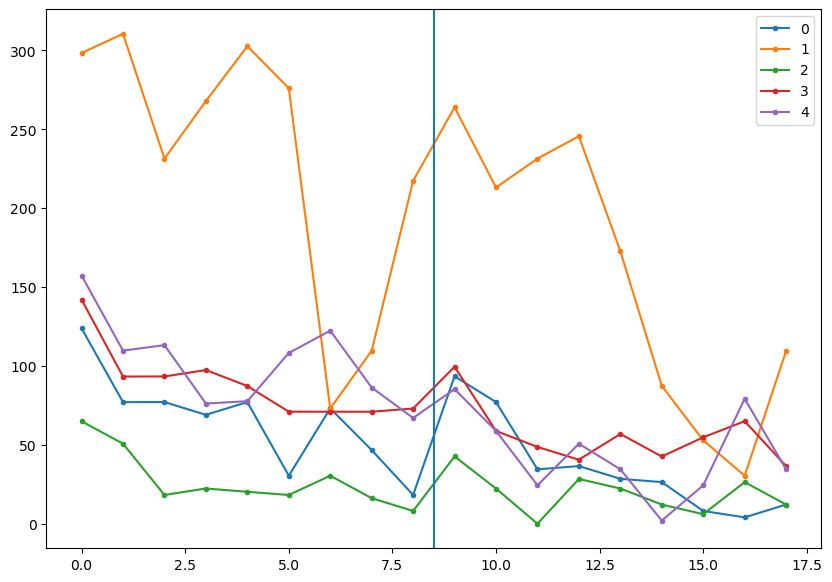

In [34]:
plt.figure(figsize=(10,7))
plt.plot(plotting_d.T,".-")
plt.axvline(8.5)
plt.legend(np.arange(plotting_d.shape[0]))

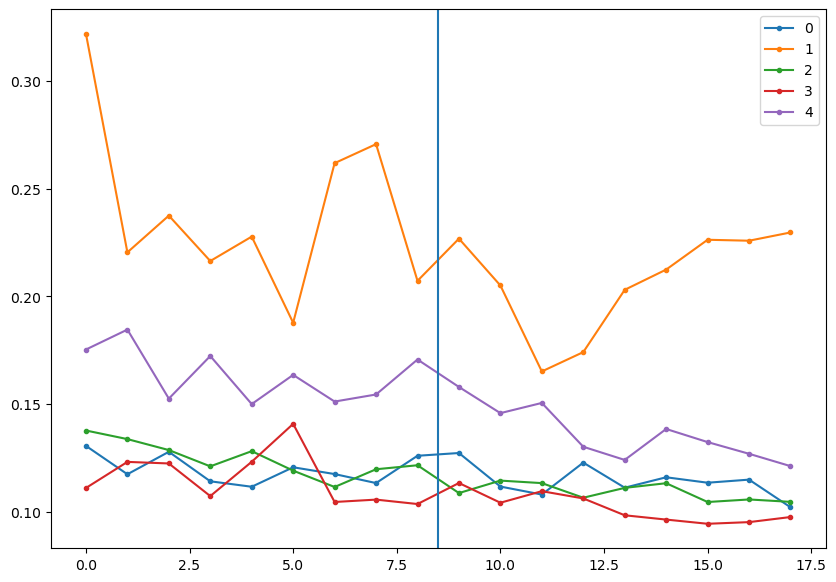

In [66]:
plt.figure(figsize=(10,7))
plt.plot(plotting_d.T,".-")
plt.axvline(8.5)
plt.legend(np.arange(plotting_d.shape[0]))

In [37]:
(df['b8']+df['b7']+df['b6']+df['b5'])/4

ID
VOL01     56.852731
VOL03    190.387988
VOL04     21.303653
VOL05     75.107475
VOL02     98.682256
dtype: float64

In [38]:
#create as dataframe and then compute some simple metrics
df = pd.DataFrame.from_dict(d1_2,orient='index',columns=['b1','b2','b3','b4','b5','b6','b7','b8','b9'
                                                    ,'b10','b11','b12','b13','b14','b15','b17','b17','b18'])
df.index.name = 'ID'
df['b9_m_b11'] = df['b9']-df['b11']


df['d1_4blk_m_d2_4blk'] =(df['b8']+df['b7']+df['b6']+df['b5'])/4-(df['b11'] +df['b12']+df['b13']+df['b14'])/4
df['d1_m_d2'] = df[['b1','b2','b3','b4','b5','b6','b7','b8','b9']].mean(axis=1)-df[['b10','b11','b12','b13','b14','b15','b17','b17','b18']].mean(axis=1)

if norm_data_to_1st_block:
    norm_txt_2 = norm_txt[0:-1] + "_"
else:
    norm_txt_2 = norm_txt
csv_out_fname = f'processing/{metric}_{norm_txt_2}by_block.csv'
df.to_csv(csv_out_fname)
print(csv_out_fname)



processing/lag_xcorr_ms_by_block_clippedData.csv


In [162]:
df['d1_4blk_m_d2_4blk']

ID
Pi1    30.320076
Pi3   -12.198416
Pi4    12.176862
Pi5    70.042584
Name: d1_4blk_m_d2_4blk, dtype: float64

In [157]:
df['d1_m_d2']

ID
Pi1    -0.127074
Pi3   -55.052251
Pi4     0.005365
Pi5    60.924481
Name: d1_4blk_m_d2_4blk, dtype: float64

9 blocks
9 blocks
9 blocks
9 blocks
9 blocks
9 blocks
9 blocks
9 blocks


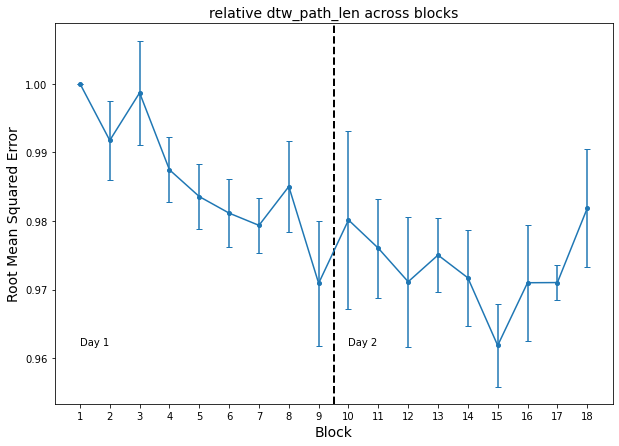

In [119]:
#summarize the data for plotting
norm_data_to_1st_block = True

metric = 'dtw_path_len'
good_data_vec = np.ones(27,dtype=bool)
d1_2 = {}
for pi in PiD1.keys():
    d1_2[pi] = np.hstack([compute_block_mean(PiD1[pi],metric=metric,good_data_vec=good_data_vec),
                          compute_block_mean(PiD2[pi],metric=metric,good_data_vec=good_data_vec)])


if norm_data_to_1st_block:
    norm_txt = 'relative '
else:
    norm_txt = ""
for idx,pi in enumerate(d1_2):
    if idx ==0:
        plotting_d = np.zeros((len(d1_2.keys()),d1_2[pi].shape[0]))
    plotting_d[idx,:] = d1_2[pi]
    if norm_data_to_1st_block:
        plotting_d[idx,:] = plotting_d[idx,:]/plotting_d[idx,0]


# plt.plot(plotting_d.mean(axis=0))
plt.figure(figsize=(10,7))
yerr = np.std(plotting_d,axis=0)/(np.sqrt(plotting_d.shape[0]))
_ = plt.errorbar(np.arange(1,plotting_d.shape[1]+1),plotting_d.mean(axis=0),yerr=yerr,capsize=3, fmt="-o", markersize=4)
_ = plt.xticks(np.arange(1,plotting_d.shape[1]+1))
_ = plt.title(f'{norm_txt}{metric} across blocks',fontsize=14)
_ = plt.axvline(9.5,color='k',linestyle='--',linewidth=2)
plt.xlabel('Block',fontsize=14)
plt.ylabel('Path Length',fontsize=14)
_ = plt.text(1,np.min(plotting_d.mean(axis=0)),'Day 1')
_ = plt.text(10,np.min(plotting_d.mean(axis=0)),'Day 2')

In [25]:
a= [0,1,2,3]
a[0:2]

[0, 1]

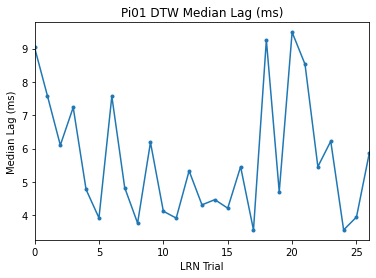

In [35]:
#Looking at the mean lag per trial in the first participant
plt.plot(PiD1['Pi3']['all']['LRN']['dtw_distance'], ls = '-', marker = '.')
plt.title('Pi01 DTW Median Lag (ms)') 
plt.xlabel('LRN Trial')
plt.ylabel('Median Lag (ms)')
plt.xlim(0,26)
plt.show()

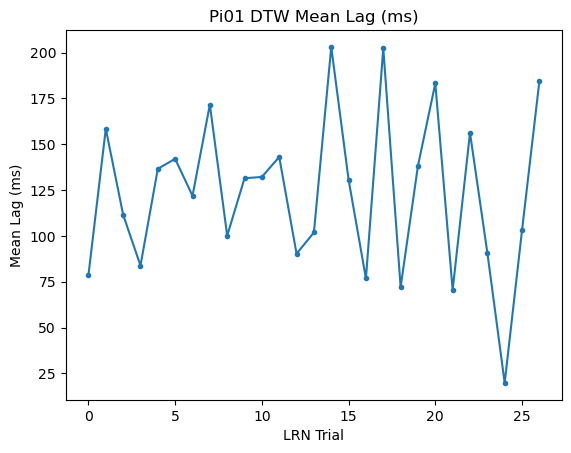

In [90]:
#Looking at the mean lag per trial 
plt.plot(PiD1['Pi1']['all']['LRN']['dtw_mean_lag_ms'],ls = '-', marker = '.')
plt.title('Pi01 DTW Mean Lag (ms)') 
plt.xlabel('LRN Trial')
plt.ylabel('Mean Lag (ms)')
plt.show()

**Plot with all participants by metric**

In [142]:
##Auto plot visualisation for all Pi's and metrics across pi's
def plotmetric(metric,day):
    for Pi in day.keys():
        my_data = (day[Pi]['all']['LRN'][metric])
       # my_data = my_data/my_data[0]
        plt.plot(my_data, ls='-', marker = '.', label=Pi)
    plt.legend(loc='upper left', bbox_to_anchor=(1,1))
    plt.title(metric + ' for all particpants')
    plt.xlabel('LRN Trial Number')
    plt.ylabel(metric)
    plt.show()


In [214]:
def plotavgmetric(metric, day):
    _d= np.array([day[Pi]['all']['LRN'][metric] for Pi in day.keys()])
    plt.errorbar(np.arange(0,27),(np.mean(_d,axis=0)), yerr = np.std(_d,axis=0)/(np.sqrt(_d.shape[0])-1), capsize=3, fmt="-o", markersize=4)
    plt.title( metric + ' Across Participants')
    plt.xlabel('LRN Trial Number')
    plt.ylabel(metric)
    plt.show()

def plotavgmetric2d(metric)
    _d= np.array([PiD1[Pi]['all']['LRN'][metric] for Pi in PiD1.keys()])
    _e= np.array([PiD2[Pi]['all']['LRN'][metric] for Pi in P2D1.keys()])
    _a= np.concatenate((_d

(54,)


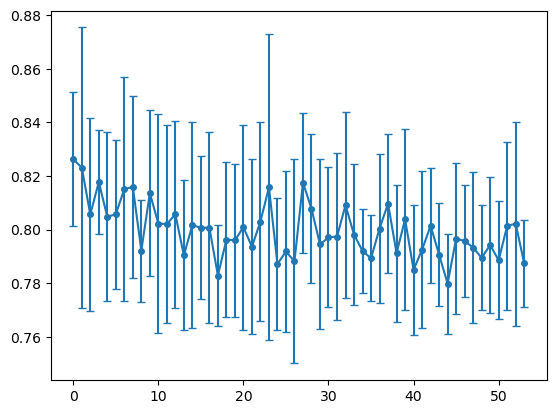

In [257]:
_d= np.array([PiD1[Pi]['all']['LRN']['dtw_path_len'] for Pi in PiD1.keys()])
_e= np.array([PiD2[Pi]['all']['LRN']['dtw_path_len'] for Pi in PiD2.keys()])
_m= np.concatenate((np.mean(_d, axis=0), np.mean(_e, axis=0)), axis=0)
yerr1 = np.std(_d,axis=0)/(np.sqrt(_d.shape[0])-1)
yerr2 = np.std(_e,axis=0)/(np.sqrt(_e.shape[0])-1)
yerr = np.concatenate((yerr1, yerr2))
plt.errorbar(np.arange(54,), _m, yerr=yerr, capsize=3, fmt="-o", markersize=4)
# plt.show()
print(_m.shape)

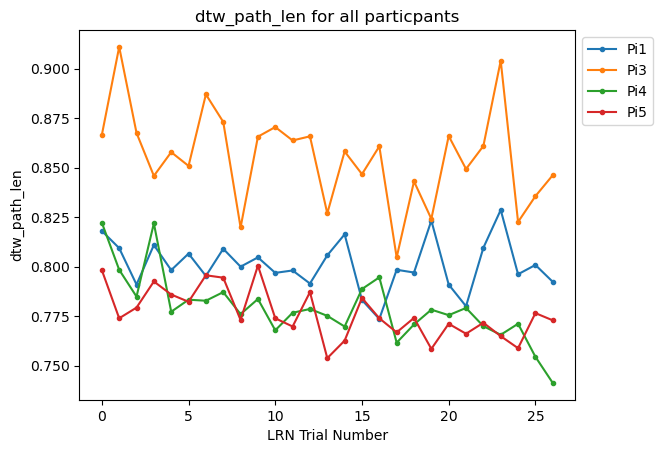

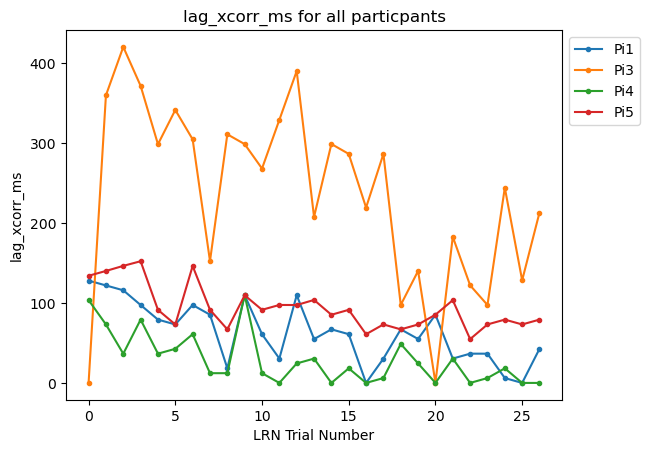

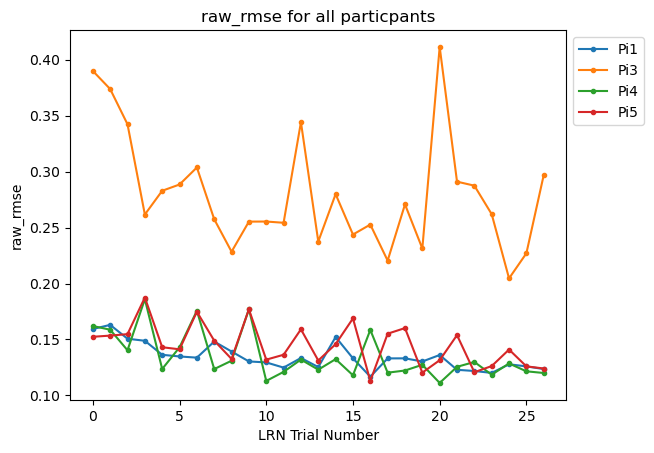

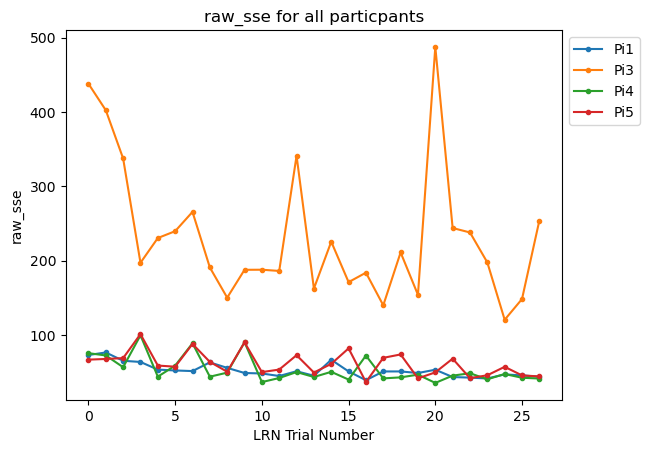

In [144]:
plotmetric('dtw_path_len', PiD1)
plotmetric('lag_xcorr_ms', PiD1)
plotmetric('raw_rmse', PiD1)
plotmetric('raw_sse', PiD1)

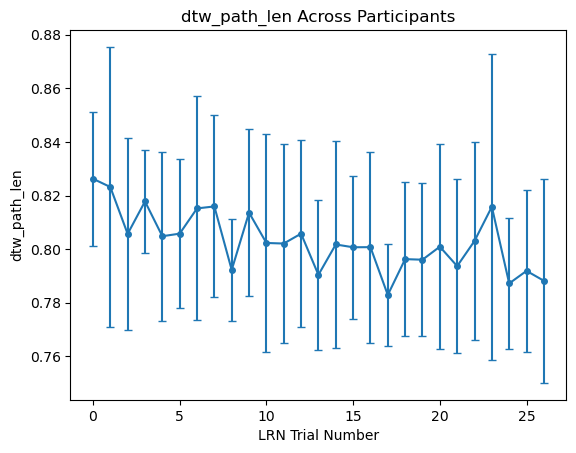

In [213]:
plotavgmetric('dtw_path_len', PiD1)

In [82]:
# print(scorePi['Pi1']['all']['LRN'].keys())

dict_keys(['lag_xcorr_ms', 'lag_lstsq_ms', 'raw_rmse', 'raw_sse', 'rmse', 'sse', 'dtw_path_len', 'dtw_distance', 'dtw_mean_lag_ms', 'dtw_median_lag_ms'])


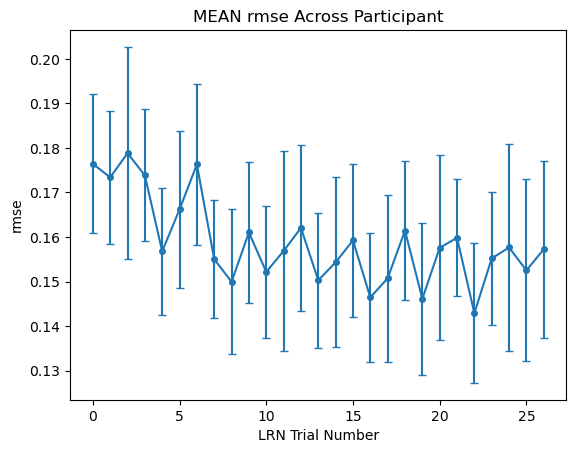

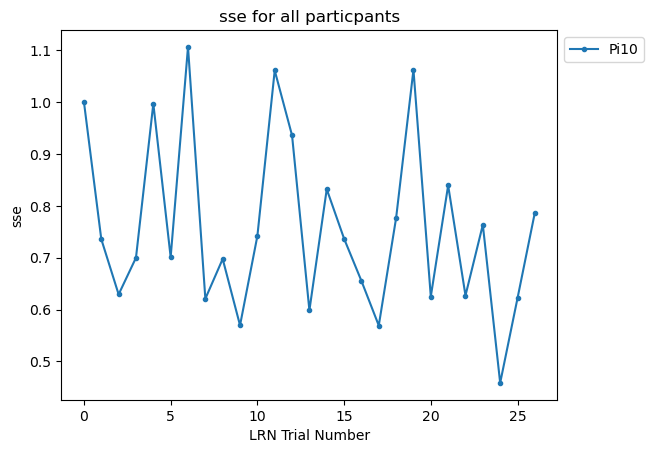

In [185]:
plotavgmetric('rmse')

**Metric across participants per trial**

In [52]:
dtwMeanLagms = np.mean([scorePi[Pi]['all']['LRN']['dtw_mean_lag_ms'] for Pi in scorePi.keys()], axis=0)
dtwMeanLagms

array([ 76.26573577, 136.23108762, 125.67847305,  68.05450807,
        86.52505274, 204.02012136,  42.41423739, 159.75668371,
       137.09731943,  92.90224108, 114.54203512,  97.61669914,
        69.96824235, 117.2608977 ,  92.79938262,  97.16193578,
       103.05042281, 137.86103418, 120.75166194,  90.23211663,
        50.69239109, 291.54812766,  95.38737546,  95.47796649,
        87.81289899, 125.18804216, 108.76076171])

In [113]:
print(scorePi['Pi1']['all']['LRN'].keys())

dict_keys(['lag_xcorr_ms', 'lag_lstsq_ms', 'raw_rmse', 'raw_sse', 'rmse', 'sse', 'dtw_path_len', 'dtw_distance', 'dtw_mean_lag_ms', 'dtw_median_lag_ms'])


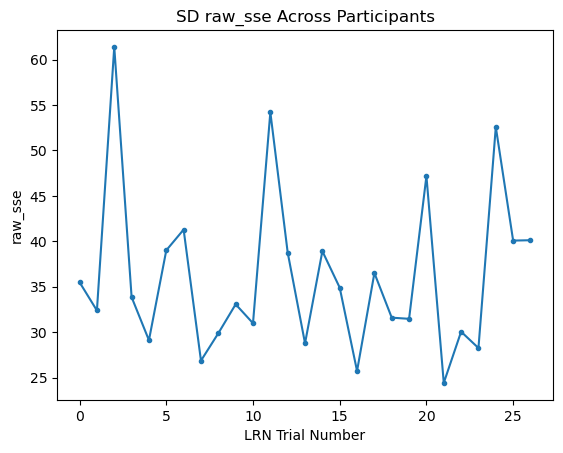

In [119]:
plotstdmetric('raw_sse')

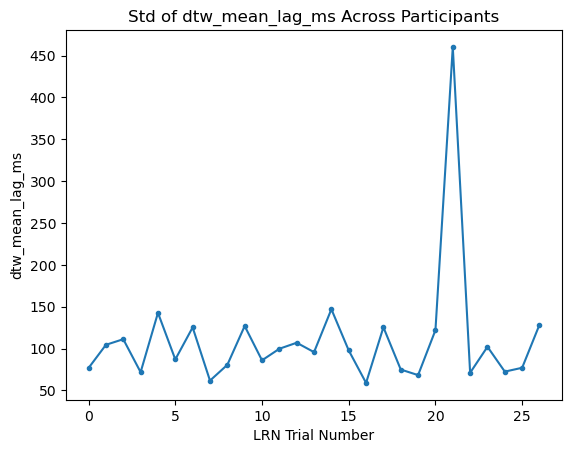

In [61]:
plt.plot(dtwMeanLagmsSD, ls='-', marker = '.')
plt.title('Std of dtw_mean_lag_ms' + ' Across Participants')
plt.xlabel('LRN Trial Number')
plt.ylabel('dtw_mean_lag_ms')
plt.show()

In [73]:
[scorePi[Pi]['all']['LRN']['dtw_mean_lag_ms'] for Pi in scorePi.keys()]

[array([ -35.45637443,  340.9373019 ,  128.85589276,   93.54883295,
          77.61728078,  296.63219449, -265.51297282,   80.63124645,
         123.80799581,  -36.43523243,  131.5212552 ,  139.54479289,
        -153.87556641,  172.25781543,  278.34723456,    6.73474017,
          57.80764707,   35.93775256,  116.98441158,   86.01808522,
         113.86031141,  356.76758468,  129.06916515,   16.81980472,
          57.98355155,  233.77483081,  122.43652883]),
 array([ 41.94390326, 135.93919385, 140.16713128, 124.02945026,
        137.93535284, 146.8947895 , 122.70461404, 139.71211222,
        210.52672448, 238.54878262, 137.26301254, 169.05955927,
        144.92076945, 162.75362783, 185.6779907 , 222.70116802,
        118.47613818, 191.46466351, 180.82317743, 138.41574284,
        172.63036891, 165.66568869, 135.32453036, 177.59518064,
        141.0026833 , 181.87362155, 163.2073014 ]),
 array([  50.93266712,  -48.5832106 , -127.91693411,    8.90580716,
         -63.07361642,  101.07987

In [ ]:
###Metrics across participants for selected with stable results

In [74]:
dtwMeanLagms = np.mean([scorePi['Pi3']['all']['LRN']['dtw_mean_lag_ms'],scorePi['Pi5']['all']['LRN']['dtw_mean_lag_ms'],scorePi['Pi6']['all']['LRN']['dtw_mean_lag_ms'],scorePi['Pi7']['all']['LRN']['dtw_mean_lag_ms']], axis=0)
dtwMeanLagms

array([ 94.67925801,  98.23309376,  68.70539468,  25.88649438,
         2.12665534, 183.00297976,  16.84008465, 132.41978986,
        66.89710677,  13.09327976,  54.4387889 ,  62.87583028,
        34.37992615,  59.7670707 ,  29.08964242,  13.46556807,
        69.94294095, 120.40509428,  72.11991325,  64.04201464,
       -62.45969054,  90.26300914,  60.23627933,   0.95556818,
        20.87319292,  80.37629948,   5.61584297])

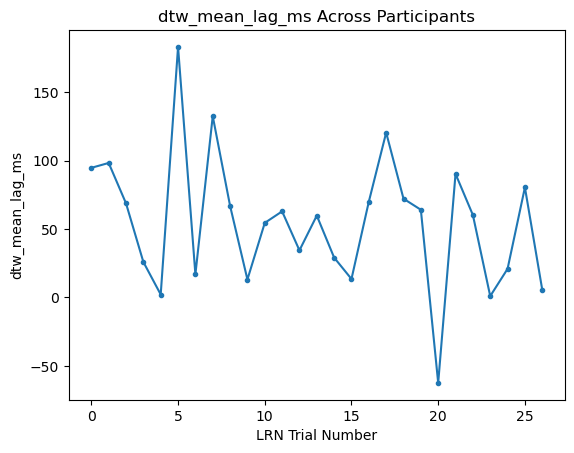

In [75]:
plt.plot(dtwMeanLagms, ls='-', marker = '.')
plt.title('dtw_mean_lag_ms' + ' Across Participants')
plt.xlabel('LRN Trial Number')
plt.ylabel('dtw_mean_lag_ms')
plt.show()